In [3]:
from latentmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc 
from tqdm.notebook import tqdm
import os

loop through each folder in PBMC_CITE_seq embeddings
estimate MI
record in df

In [14]:
# base directory for embeddings
embeddings_dir = '../embeddings/PBMC_CITEseq/'
results = []

# loop through quality and replicate subdirectories
for quality_dir in os.listdir(embeddings_dir):
    quality_path = os.path.join(embeddings_dir, quality_dir)
    if not os.path.isdir(quality_path):
        continue

    # find held-out cells
    held_out_path = os.path.join(quality_path, 'held_out_cells.h5ad')
    held_out = sc.read_h5ad(held_out_path)

    UMI_per_cell = held_out.raw.X.sum()/len(held_out)

    protein_counts = held_out.obsm['protein_counts']

    celltype_coarse = pd.get_dummies(held_out.obs['celltype.l1']).to_numpy()
    celltype_fine = pd.get_dummies(held_out.obs['celltype.l3']).to_numpy()

    # loop through embedding files
    for file in tqdm(os.listdir(quality_path), desc=f"Processing {quality_dir}"):
        if not file.endswith('.npy'):
            continue

        # extract method and fraction from filename
        method, frac = file.split('_')
        frac = frac[4:-4]

        # load embeddings
        embedding_path = os.path.join(quality_path, file)
        embeddings = np.load(embedding_path)

        # estimate MI
        pmis, _, _ = lmi.estimate(embeddings, protein_counts, quiet=True, batch_size=2048)
        protein_mi = np.nanmean(pmis)

        # estimate MI for cell type
        pmis, _, _ = lmi.estimate(embeddings, celltype_coarse, quiet=True, batch_size=2048)
        ct_coarse_mi = np.nanmean(pmis)

        pmis, _, _ = lmi.estimate(embeddings, celltype_fine, quiet=True, batch_size=2048)
        ct_fine_mi = np.nanmean(pmis)

        # save result
        results.append({
            'Quality': quality_dir.split('_')[0],
            'UMI per cell' : UMI_per_cell,
            'Replicate': quality_dir.split('_')[1],
            'Fraction': float(frac),

            # watch out ! this needs to be tweaked if we change hold out size
            'Cell number' : int(float(frac)*3*len(held_out)),
            'Method': method,
            'Protein MI': protein_mi,
            'Cell type coarse MI': ct_coarse_mi,
            'Cell type fine MI': ct_fine_mi
        })

Processing Q0.464_rep0:   0%|          | 0/13 [00:00<?, ?it/s]

epoch 278 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q1.000_rep0:   0%|          | 0/13 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

In [15]:
df = pd.DataFrame(results)
df

,Quality,UMI per cell,Replicate,Fraction,Cell number,Method,Protein MI,Cell type coarse MI,Cell type fine MI
0,Q0.464,3784.577635,rep0,0.001,114,VAE,3.547367,2.089643,3.080356
1,Q0.464,3784.577635,rep0,0.001,114,PCA,3.589099,2.005444,3.035182
2,Q0.464,3784.577635,rep0,0.001,114,RandomProjection,2.502718,1.855431,2.387751
3,Q0.464,3784.577635,rep0,0.001,114,nanoTxformer,3.078061,2.237268,3.084801
4,Q0.464,3784.577635,rep0,0.010,1140,VAE,3.903721,2.156195,3.143352
5,Q0.464,3784.577635,rep0,0.010,1140,PCA,3.916656,2.078247,3.140094
6,Q0.464,3784.577635,rep0,0.010,1140,RandomProjection,2.471856,1.810457,2.393612
7,Q1.000,8153.868320,rep0,0.001,114,VAE,3.940203,2.222895,3.250361
8,Q1.000,8153.868320,rep0,0.001,114,PCA,4.084016,2.077583,3.345902
9,Q1.000,8153.868320,rep0,0.001,114,RandomProjection,2.828763,1.910749,2.525251


<Axes: xlabel='Fraction', ylabel='Protein MI'>

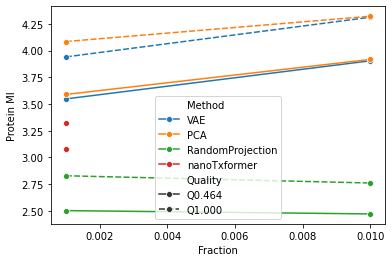

In [16]:
sns.lineplot(df, x='Fraction', y='Protein MI', style='Quality', 
             hue='Method', marker='o')

<Axes: xlabel='Fraction', ylabel='Cell type coarse MI'>

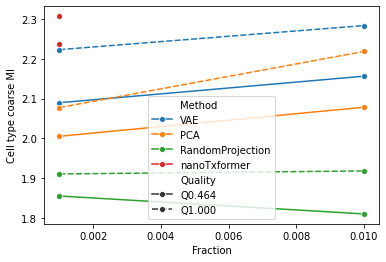

In [17]:
sns.lineplot(df, x='Fraction', y='Cell type coarse MI', style='Quality', 
             hue='Method', marker='o')

<Axes: xlabel='Fraction', ylabel='Cell type fine MI'>

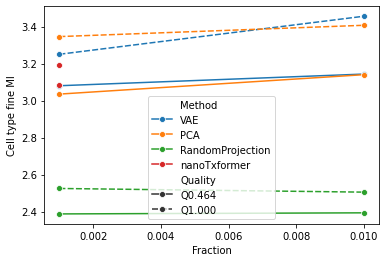

In [18]:
sns.lineplot(df, x='Fraction', y='Cell type fine MI', style='Quality', 
             hue='Method', marker='o')